In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version= 1)
X, y = mnist['data'], mnist['target']
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

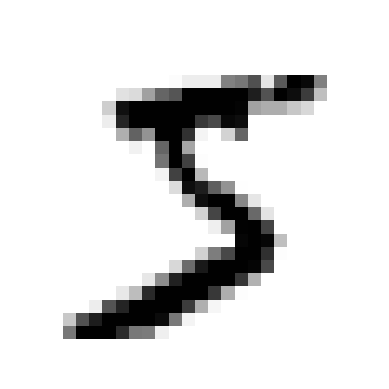

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off") # 关闭坐标轴，让图像更清晰
plt.show()

In [7]:
y.iloc[0]

'5'

In [8]:
import numpy as np

# 设置随机种子
np.random.seed(42)
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 训练一个二分类器

## 先训练一个识别单独数字的model


In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### 使用随机梯度下降

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state= 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# 性能评估

## 使用交叉验证测量准确率

### 手动实现K折交叉验证

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits= 3, random_state= 42, shuffle= True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds) # 计算预测正确的数量
    print(n_correct / len(y_pred))

KeyError: "None of [Index([    1,     3,     4,     5,     7,     8,    10,    11,    12,    13,\n       ...\n       59984, 59985, 59987, 59988, 59989, 59991, 59993, 59994, 59996, 59998],\n      dtype='int32', length=40000)] are in the [columns]"

## 使用scikit-learn的`cross_val_predict`函数

In [13]:
from sklearn.model_selection import cross_val_predict
cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)

array([ True, False, False, ...,  True, False, False])

# 创建一个base分类器
## 这个简单单分类器的准确率也有90 说明对于分类器来讲 准确率不能成为一个很好的指标

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_predict(never_5_clf, X_train, y_train_5, cv= 3, scoring= "accuracy")

TypeError: got an unexpected keyword argument 'scoring'

# 计算混淆矩阵

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)  # 这个函数返回预测的结果

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:

# 一个完美的混淆矩阵
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [18]:
# 或者可以计算精度或者召回率 公式为 TP / (TP + FP) 和 TP / (TP + FN)
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


# 将precision score和recall score结合起来 得到F1score 公式为 2 * (precision * recall) / (precision + recall)

### 只有当两个分数都比较高的时候f1分数才会高一点

In [19]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


# 精度/ 召回率权衡

In [20]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

# 如何决定怎么确定阈值来调整召回率和准确率之间的关系
## 1.使用cross_val_predict函数计算每个实例的分数
## 2.使用prediction_recall_curve函数计算召回率和准确率
## 3.绘制precision-recall曲线

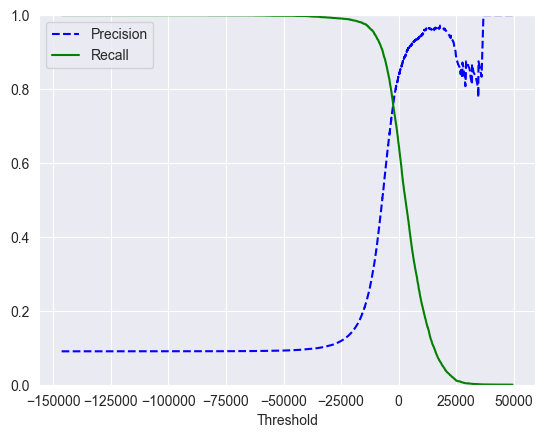

In [23]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3, method= "decision_function")
precisions, recall, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label= "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label= "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc= "upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recall, thresholds)
plt.show()

In [24]:
# 假设将精度设置为90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

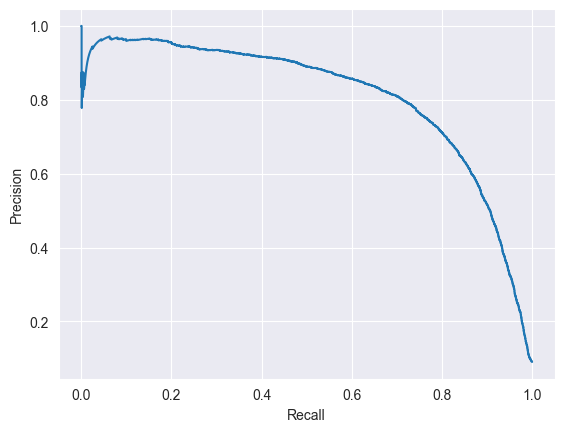

In [26]:
# 绘制召回率和精度之间的关系图
plt.plot(recall, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [27]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## 绘制ROC曲线


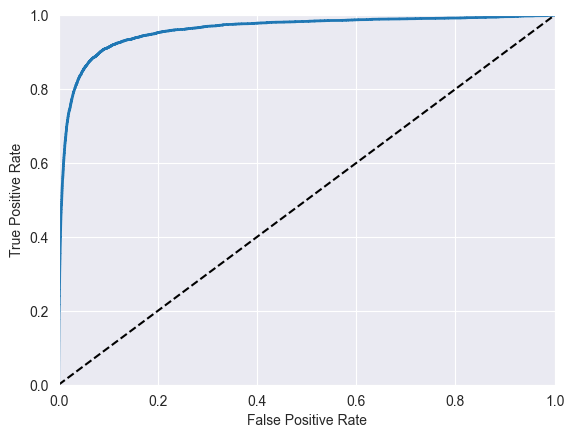

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label= None):
    plt.plot(fpr, tpr, linewidth= 2, label= label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
# 计算ROC曲线下面积AUC
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


# 选择ROC还是PR曲线
## 当正类特别少或者你更加关注假正类而不是假父类的时候选择PR
## 反之选择ROC曲线

### 训练一个RandomForestClassifier

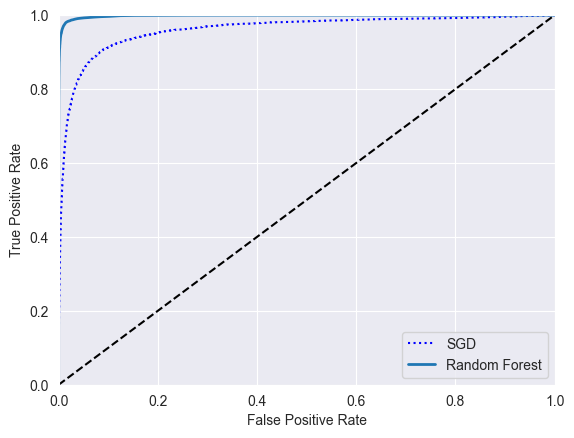

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state= 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv= 3, method= "predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label= "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc= "lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# 多类分类器

In [32]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [33]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(np.argmax(some_digit_scores))
svm_clf.classes_[5]

5


C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


5

# 使用一对多分类器

In [34]:
from sklearn.multiclass import OneVsOneClassifier
ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [35]:
sgd_clf.decision_function([some_digit])

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [37]:
cross_val_predict(sgd_clf, X_train, y_train, cv= 3, method= "decision_function")

NameError: name 'cross_val_score' is not defined

In [41]:
# 对数据进行缩放
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv= 3)

KeyboardInterrupt: 

# 误差分析

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


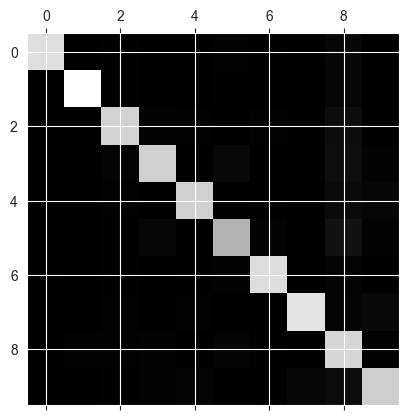

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv= 2)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap= plt.cm.gray)
plt.show()

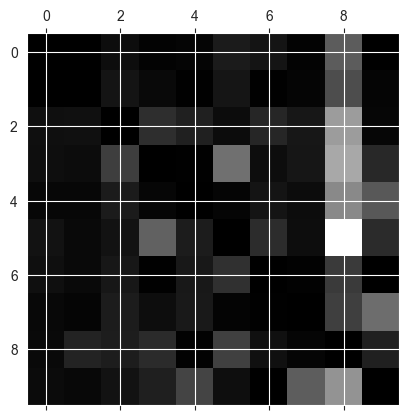

In [44]:
# 比较混淆矩阵的错误率
# 每行代表实际类 每列表示预测类
row_sums = conf_mx.sum(axis= 1, keepdims= True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()

# 多标签分类

In [45]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [46]:
knn_clf.predict([some_digit])

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [49]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv= 3)
f1_score(y_multilabel, y_train_knn_pred, average= "weighted")

0.9778357403921755

In [50]:
f1_score(y_multilabel, y_train_knn_pred, average= "weighted")

0.9778357403921755